# How-To Define Areas of Interest and Aggregate Fixation Metrics

After collecting data with your Pupil Invisible glasses and applying Enrichments in Pupil Cloud, you will often want to know which elements in the scene were looked at, and describe how they were looked at with a few metrics. A common approach to achieve this goal uses Areas of Interest (AOIs). AOIs are regions in the image, defined by the researcher based on the question they are trying to answer. 

In this guide we will show you how to mark AOIs on a reference image, how to label which AOI a fixation was made on, and how to aggregate metrics from fixation data from the [Reference Image Mapper][rim_link] inside these AOIs.

We will work in the context of an [Art Gallery][art_gallery_link], where each painting is an Area of Interest. We are addressing the questions "How many visitors looked at each painting?", "How soon after arriving did visitors look at each painting?", and "How long did visitors look at each painting?".

For a more detailed walkthrough of this analysis, you can check out this [blog post][blog_post_link].

[rim_link]: https://docs.pupil-labs.com/invisible/explainers/enrichments/#reference-image-mapper
[art_gallery_link]: https://pupil-labs.com/blog/news/demo-workspace-walkthrough-part1/
[blog_post_link]: https://pupil-labs.com/blog/news/demo-workspace-walkthrough-part2/

## Install the Neccessary Dependencies

This guide uses a few external libraries. If you haven't installed them, you can do that with the line below.

In [1]:
%pip install matplotlib pandas opencv-python seaborn

Note: you may need to restart the kernel to use updated packages.


## Define the Path to Your Enrichment Folder

In [2]:
# Attention: this path will be different for different enrichments and users
path_to_reference_image_mapper = (
    "./Viewing_Paintings_REFERENCE-IMAGE-MAPPER_multiple_paintings_standing_csv"
)

## Load the Reference Image and Mark AOIs with cv2
The reference image ('reference_image.jpeg') will be located inside the enrichment folder. 

We will load it and mark the AOIs using the function "selectROIs" from [opencv][opencv_link]. 
When you execute the cell below, a window with the reference image will appear.
Mark the AOIs by clicking in any corner where you want your AOI to start. Then drag while keeping the mouse pressed until the blue rectangle is sized correctly. Release the mouse and hit enter or the space bar when you are happy with your selection. If you are not, you can start over by simply marking a new area. 
Repeat this process until you have marked all AOIs needed. Close the selection with the escape key.

[opencv_link]: https://opencv.org/

In [3]:
import cv2

# load the reference image
reference_image = cv2.imread(f"{path_to_reference_image_mapper}/reference_image.jpeg")
# convert color format to RGB
reference_image = cv2.cvtColor(reference_image, cv2.COLOR_BGR2RGB)

# resize the image before labelling AOIs makes the image stay in the screen boundaries
scaling_factor = 0.25
scaled_image = reference_image.copy()
scaled_image = cv2.resize(
    scaled_image, dsize=None, fx=scaling_factor, fy=scaling_factor
)

# mark the AOIs
scaled_aois = cv2.selectROIs("AOI Annotation", scaled_image)
cv2.destroyAllWindows()

# scale back the position of AOIs
aois = scaled_aois / scaling_factor
print(scaled_aois)

[[130  39 139 132]
 [368 177  89 108]
 [467  79 164 210]
 [648 197 109 141]
 [764 235 109  98]
 [811  64 108 105]
 [220 319 411 213]
 [658 348 210 158]
 [172 626 112 112]
 [309 581  85  87]
 [494 578 141 164]
 [645 518 214 232]]


## Overlaying Areas of Interest on the Reference Image
Now, we visually check whether the AOIs we defined match up with our reference image.

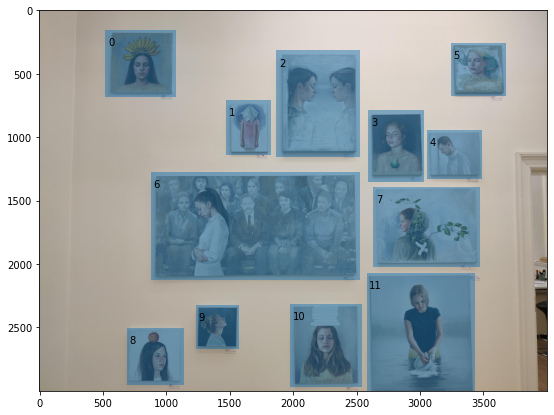

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import patches

# list of the painting ids as names
paintings = [idx for idx in range(len(aois))]

# plot the reference image and overlay the AOIS
marked_ref_fig = plt.figure(figsize=(10, 7))
plt.imshow(np.asarray(reference_image))

# define a function to draw rectangles on the image
def plot_aoi_patches(aois, ax):
    for idx, aoi in enumerate(aois):
        ax.add_patch(
            patches.Rectangle(aoi, *aoi[2:], alpha=0.5)
        )
        ax.text(aoi[0] + 20, aoi[1] + 120, f"{idx}", color="black")

# display the AOI patches
plot_aoi_patches(aois, plt.gca())

If you notice hat some AOIs are not placed correctly, you can manually manipulate the location by changing entries in the aoi array.

## Detecting Fixations Inside Areas of Interest 

Next up, we want to match the fixation coordinates to the AOIs. This is comparable to asking for every x/y coordinate pair that defines a fixation if that pair is inside any of the rectangles.

In [5]:
import pandas as pd

# import fixation data
fixations = pd.read_csv(f"{path_to_reference_image_mapper}/fixations.csv")
# select fixations to the reference image
fixations = fixations[fixations["fixation detected in reference image"]]

def check_in_rect(fixation_data, rectangle_coordinates):
    """
    returns an array with the length of fixation_data, which is True, when the entry in fixation_data
    was inside rectangle_coordinates and False otherwise.
    """

    # unpack the rectangle coordinates
    rect_x, rect_y, rect_width, rect_height = rectangle_coordinates

    # check if the fixation was within the x- and y-borders
    x_hit = fixation_data["fixation x [px]"].between(rect_x, rect_x + rect_width)
    y_hit = fixation_data["fixation y [px]"].between(rect_y, rect_y + rect_height)

    return x_hit & y_hit


# create a new column of 'None's in our data frame
fixations["AOI"] = None

# assign the AOI ID to those fixations that were inside the AOI
for aoi_id, aoi in enumerate(aois):
    fixations.loc[check_in_rect(fixations, aoi), "AOI"] = paintings[aoi_id]

fixations.head()

,section id,recording id,fixation id,start timestamp [ns],end timestamp [ns],duration [ms],fixation detected in reference image,fixation x [px],fixation y [px],AOI
0,3cd54e6f-f12e-468c-9a7b-6afffd5f0379,54a0deee-23dd-48f4-806e-6fdb519d6a7c,248,1636035560036503914,1636035560236515914,200,True,2419.0,2138.0,None
1,3cd54e6f-f12e-468c-9a7b-6afffd5f0379,54a0deee-23dd-48f4-806e-6fdb519d6a7c,249,1636035560256651914,1636035560480505914,223,True,2224.0,1717.0,6
2,3cd54e6f-f12e-468c-9a7b-6afffd5f0379,54a0deee-23dd-48f4-806e-6fdb519d6a7c,250,1636035560500491914,1636035560740669914,240,True,2427.0,1559.0,6
3,3cd54e6f-f12e-468c-9a7b-6afffd5f0379,54a0deee-23dd-48f4-806e-6fdb519d6a7c,251,1636035560776494914,1636035560972502914,196,True,1935.0,1119.0,2
4,3cd54e6f-f12e-468c-9a7b-6afffd5f0379,54a0deee-23dd-48f4-806e-6fdb519d6a7c,252,1636035561008557914,1636035561168510914,159,True,2828.0,1668.0,7


You can now see the new column "AOI". This column indicates whether gaze fell inside a given AOI.

## Aggregating Fixation Metrics Inside AOIs 

## AOI Hit Rate

The Hit Rate of an AOI is defined as the proportion of subjects that looked at the AOI at least once. 
A Hit Rate of 100% means, every person we recorded looked at the AOI, a Hit Rate of 50% indicates that only every second person looked at the AOI, etc.

In [6]:
# first, we extract the hit count
fixation_counts = (
    fixations.pivot_table(
        index="section id",
        columns="AOI",
        values="fixation id",
        fill_value=0,
        aggfunc="count",
    )
    .unstack()
    .to_frame()
    .rename(columns={0: "fixation count"})
)
fixation_counts.reset_index(inplace=True)

# and boil it down to yes/no
hits = fixation_counts.copy()
hits["hit"] = hits["fixation count"] > 0

The result is a table that tells us for every AOI and recording id, how often a fixation was detected inside the AOI for that recording (fixation count), and if there was at least one fixation detected (hit).

## Visualizing Aggregated Data
To visualize the data, we use the library seaborn. Seaborn is a library for statistical data visualization that allows us to aggregate and plot the data in a few lines of code.

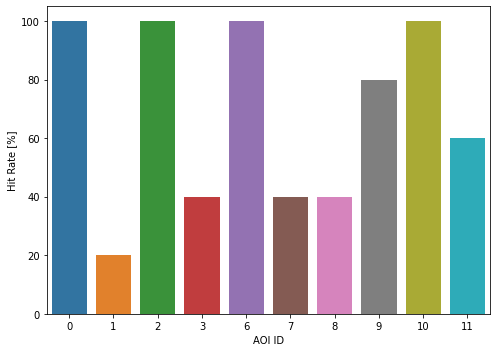

In [7]:
import seaborn as sns
hit_rate_fig = plt.figure(figsize=(7, 5))

# Get the mean hit rate over observers and plot
proportional_hits = hits.groupby("AOI").mean().reset_index()
proportional_hits.loc[:, "hit"] = proportional_hits["hit"] * 100

sns.barplot(x="AOI", y="hit", data=proportional_hits, ax=plt.gca())

plt.xlabel("AOI ID")
plt.ylabel("Hit Rate [%]")

plt.tight_layout()

# Time to First Contact
Time to First Contact measures how long it took observers to look at an AOI for the first time. Short times to first contact mean that the observers looked at the AOI early during the section.

We can compute time to first contact as the difference between the time when the first fixation was registered on an AOI and the time when the section started. So first, we need the information when each section started.

In [8]:
# loading sections
sections = pd.read_csv(f"{path_to_reference_image_mapper}/sections.csv")
sections.head()

# create a new column in the fixation dataframe
fixations["aligned timestamp [s]"] = None

# compute the difference for the respective section
for section in sections["section id"]:
    section_idx = fixations[fixations["section id"] == section].index
    section_start_time = sections.loc[
        sections["section id"] == section, "section start time [ns]"
    ].values
    # update the value of the aligned time stamp
    fixations.loc[section_idx, "aligned timestamp [s]"] = (
        fixations.loc[section_idx, "start timestamp [ns]"] - section_start_time
    ) / 1e9

## Extract Time to First Contact
Next, we aggregate the fixation data by section id and AOI, and extract the lowest value from the "aligned timestamp [s]" column. This is the time when the very first fixation on that AOI appeared in this session.

In [13]:
first_contact = pd.DataFrame(
    fixations.groupby(["section id", "AOI"]).min()["aligned timestamp [s]"]
)
first_contact.reset_index(inplace=True)

first_contact.head()

,section id,AOI,aligned timestamp [s]
0,3cd54e6f-f12e-468c-9a7b-6afffd5f0379,0,2.848527
1,3cd54e6f-f12e-468c-9a7b-6afffd5f0379,2,0.656495
2,3cd54e6f-f12e-468c-9a7b-6afffd5f0379,6,0.136652
3,3cd54e6f-f12e-468c-9a7b-6afffd5f0379,7,0.888558
4,3cd54e6f-f12e-468c-9a7b-6afffd5f0379,10,4.696511


## Visualize Time to First Contact

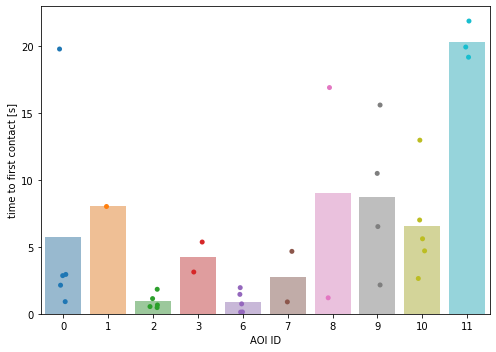

In [10]:
# create the figure
first_contact_fig = plt.figure(figsize=(7, 5))

# plot the mean values as bar plots
sns.barplot(
    x="AOI",
    y="aligned timestamp [s]",
    data=first_contact,
    ci=None,
    ax=plt.gca(),
    alpha=0.5,
)
# add individual data as dots
sns.stripplot(
    x="AOI",
    y="aligned timestamp [s]",
    data=first_contact,
    ax=plt.gca(),
)
# set title and axis labels
plt.ylabel("time to first contact [s]")
plt.xlabel("AOI ID")
plt.tight_layout()

# Dwell Time

Dwell Time describes the total time an observer has looked at a given AOI. We can find the dwell time by summing up the durations of all fixations we detected, seperately for each AOI. Again, we group our data frame, and then sum up all the fixation duration we recorded during our study.

In [11]:
dwell = fixations.groupby(["section id", "AOI"]).sum()["duration [ms]"]
dwell = pd.DataFrame(dwell).sort_values("AOI")
dwell.reset_index(inplace=True)

# translate the dwell time in milliseconds to seconds
dwell["duration [s]"] = dwell["duration [ms]"] / 1000

dwell.head()

,section id,AOI,duration [ms],duration [s]
0,3cd54e6f-f12e-468c-9a7b-6afffd5f0379,0,544.0,0.544
1,701607c8-fd13-4c98-b5cd-2bf7e1b5818a,0,1016.0,1.016
2,5ee66696-5b84-4814-bb13-b96dee92dfba,0,408.0,0.408
3,93f3ae11-30aa-45a9-b5bd-57b0ed6bad95,0,2149.0,2.149
4,89011032-f86b-41fa-a7c7-1c39e734113a,0,1003.0,1.003


## Visualize Dwell Time

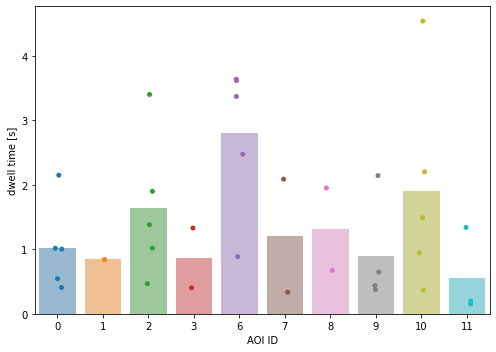

In [12]:
# plot the average time spent on each image
dwell_time_fig = plt.figure(figsize=(7, 5))

sns.barplot(
    x="AOI",
    y="duration [s]",
    data=dwell,
    ci=None,
    ax=plt.gca(),
    alpha=0.5,
)

sns.stripplot(
    x="AOI", 
    y="duration [s]", 
    data=dwell, 
    ax=plt.gca()
)

plt.ylabel("dwell time [s]")
plt.xlabel("AOI ID")
plt.tight_layout()

## Conclusion

You have seen an approach to manually mark AOIs on an image, find fixations with x/y coordinates inside these images and summarize fixation metrics. The approach will work for any setup where your gaze coordinates are aligned with the coordinates of a given reference image.